<a href="https://colab.research.google.com/github/Mateo289/Teoria_senales/blob/main/Modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

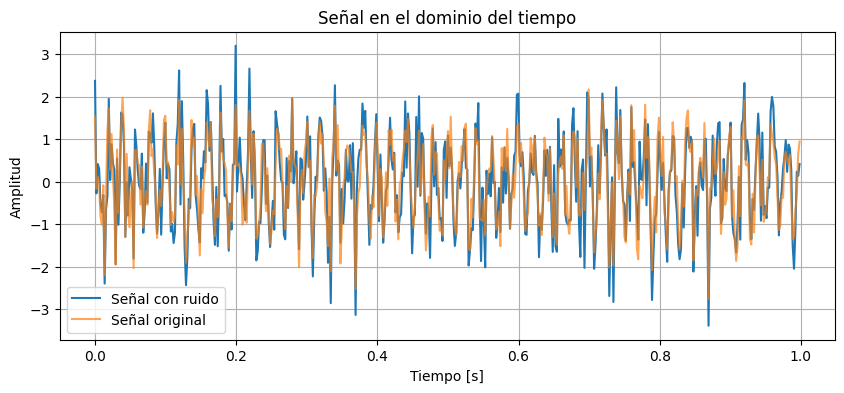

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0523 - mae: 0.1278 - val_loss: 9.1496e-05 - val_mae: 0.0074
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.3401e-05 - mae: 0.0066 - val_loss: 3.1289e-05 - val_mae: 0.0036
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3641e-05 - mae: 0.0024 - val_loss: 1.5467e-05 - val_mae: 0.0018
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3782e-06 - mae: 8.8688e-04 - val_loss: 1.2885e-05 - val_mae: 0.0012
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5578e-07 - mae: 4.2928e-04 - val_loss: 1.2572e-05 - val_mae: 0.0010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0243e-07 - mae: 3.2789e-04 - val_loss: 1.2555e-05 - val_mae: 0.0010
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.8230e-07 - mae: 3.1003e-04 - val_loss: 1.2552e-05 - val_mae: 0.0010
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.4702e-07 - mae: 3.0224e-04 - val_loss: 1.2553e-05 - 

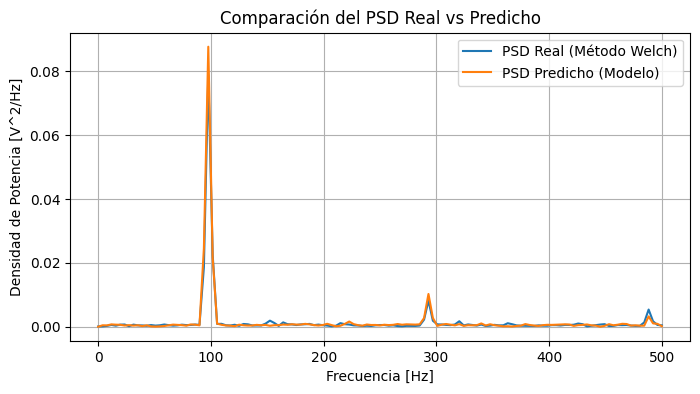

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import welch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Configuración global
fs = 1000  # Frecuencia de muestreo
T = 1  # Duración de la señal en segundos
t = np.linspace(0, T, 512, endpoint=False)  # 512 muestras


# Clase para generación y preprocesamiento de datos
class DataGenerator:
    def __init__(self, num_samples=100):
        self.num_samples = num_samples

    def generate_signals(self):
        X, Y = [], []
        for _ in range(self.num_samples):
            # Generar señal original
            w0 = 2 * np.pi * 50  # Frecuencia base (50 Hz)
            x_original = (
                np.cos(w0 * t)
                - (1 / 3) * np.sin(3 * w0 * t)
                + (1 / 5) * np.cos(5 * w0 * t)
            )

            # Añadir ruido
            ruido = np.random.normal(0, 0.5, t.shape)
            x_con_ruido = x_original + ruido

            # Calcular PSD
            f, psd = welch(x_con_ruido, fs, nperseg=256)

            X.append(x_con_ruido)
            Y.append(psd)

        return np.array(X), np.array(Y)

    @staticmethod
    def split_data(X, Y, test_size=0.2, random_state=42):
        return train_test_split(X, Y, test_size=test_size, random_state=random_state)

    @staticmethod
    def visualize_signal(t, x_original, x_con_ruido):
        plt.figure(figsize=(10, 4))
        plt.plot(t, x_con_ruido, label="Señal con ruido")
        plt.plot(t, x_original, label="Señal original", alpha=0.7)
        plt.legend()
        plt.title("Señal en el dominio del tiempo")
        plt.xlabel("Tiempo [s]")
        plt.ylabel("Amplitud")
        plt.grid()
        plt.show()


# Clase para construir y entrenar el modelo
class PSDPredictor:
    def __init__(self, input_shape, n_frequencies):
        self.model = self.build_model(input_shape, n_frequencies)

    @staticmethod
    def build_model(input_shape, n_frequencies):
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(n_frequencies, activation='linear')
        ])
        return model

    def compile_model(self, optimizer='adam', loss='mse', metrics=['mae']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def train_model(self, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=1):
        return self.model.fit(
            X_train, Y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test, Y_test),
            verbose=1
        )

    def predict(self, X_test):
        return self.model.predict(X_test)

    @staticmethod
    def visualize_results(f, Y_test, Y_pred):
        plt.figure(figsize=(8, 4))
        plt.plot(f, Y_test[0], label="PSD Real (Método Welch)")
        plt.plot(f, Y_pred[0], label="PSD Predicho (Modelo)")
        plt.title("Comparación del PSD Real vs Predicho")
        plt.xlabel("Frecuencia [Hz]")
        plt.ylabel("Densidad de Potencia [V^2/Hz]")
        plt.legend()
        plt.grid()
        plt.show()


# Función principal para coordinar el flujo de trabajo
def main():
    # Generación de datos
    data_gen = DataGenerator(num_samples=100)
    X, Y = data_gen.generate_signals()

    # División de datos
    X_train, X_test, Y_train, Y_test = data_gen.split_data(X, Y)

    # Visualización de una señal de ejemplo
    data_gen.visualize_signal(t, X[0], X[0] + np.random.normal(0, 0.5, t.shape))

    # Obtener el número de frecuencias
    n_frequencies = Y_train.shape[1]

    # Construcción y entrenamiento del modelo
    psd_predictor = PSDPredictor(input_shape=(512,), n_frequencies=n_frequencies)
    psd_predictor.compile_model()
    history = psd_predictor.train_model(X_train, Y_train, X_test, Y_test)

    # Evaluación y predicción
    Y_pred = psd_predictor.predict(X_test)

    # Visualización de resultados
    psd_predictor.visualize_results(np.linspace(0, fs / 2, len(Y_test[0])), Y_test, Y_pred)


# Ejecutar el flujo principal
if __name__ == "__main__":
    main()
